<a href="https://colab.research.google.com/github/Howl06/practice/blob/main/torch/Brain_Tumor_Segmentation_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# upgrate imgaug version,  e.g: 0.4.0
!pip install imgaug==0.4.0 --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import imgaug

import torch
from torch import nn
import torchvision
import torchsummary

torch.__version__, imgaug.__version__

('2.0.1+cu118', '0.4.0')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
# Check GPU device
!nvidia-smi

Sat May 27 11:44:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Download data

In [5]:
# download dataset
!gdown --id 1ukyrNphtS_FT2szqHOlc491Rx6kMuR6H --output brain-mri-seg.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ukyrNphtS_FT2szqHOlc491Rx6kMuR6H
To: /content/brain-mri-seg.zip
100% 130M/130M [00:03<00:00, 37.3MB/s]


In [6]:
# unzip file
!unzip -q brain-mri-seg.zip

#### Data Analysis


---

brain-mri-seg


*   train/
    *   pat_1.tif
    *   pat_1**_mask**.tif
    *   pat_2.tif
    *   pat_2**_mask**.tif
    *   ...
*   test/
    *   ...



In [7]:
# random pick 1 image and mask
mask_paths = glob('brain-mri-seg/train/*_mask.tif') # read all mask file
mask_path = np.random.choice(mask_paths) # sample 1 mask file
img_path = mask_path.replace('_mask', '') # convert path from mask to image
# read image and mask
img = cv2.imread(img_path)
mask = cv2.imread(mask_path)

print('img_path: ', img_path, '\nmask path:',  mask_path)
print(f'img.shape : {img.shape},\nmask.shape: {mask.shape}')

img_path:  brain-mri-seg/train/TCGA_DU_8168_19970503_24.tif 
mask path: brain-mri-seg/train/TCGA_DU_8168_19970503_24_mask.tif
img.shape : (256, 256, 3),
mask.shape: (256, 256, 3)


Image shape: (H, W, C)

*   C: 3 MRI channels(modalities)

Mask  shape: (H, W, C)

*   C: 3, all channels with same values
    * 0: background
    * 1: tumor

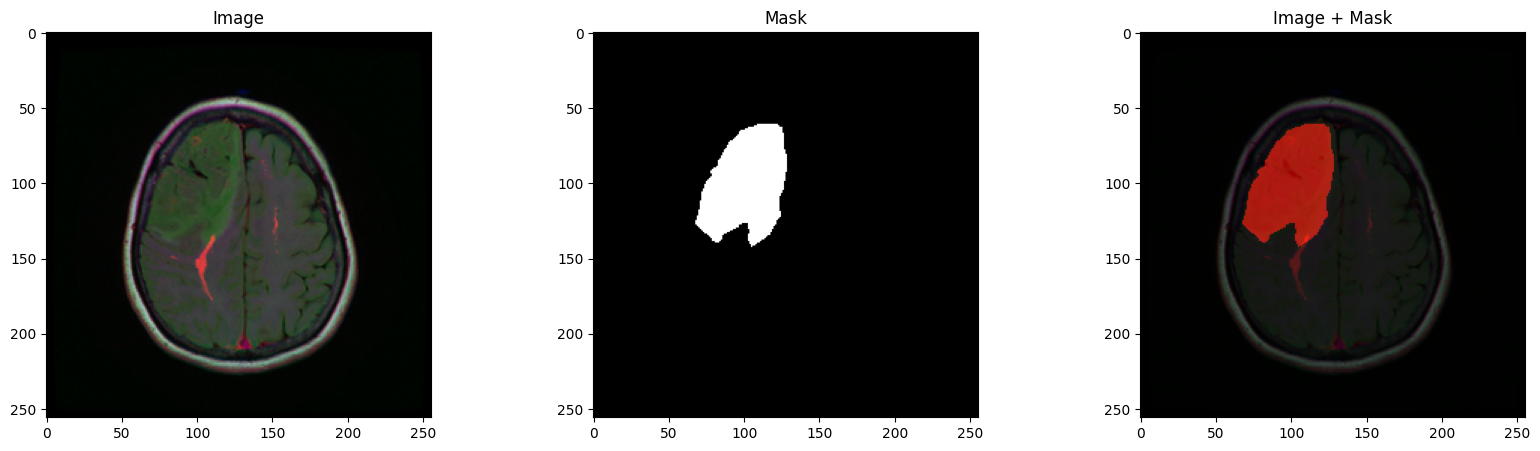

In [8]:
# show image & mask
def plot_img_mask(img, mask):
    plt.figure(figsize=(20, 5))
    plt.subplot(1,3,1)
    plt.title('Image')
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.title('Mask')
    plt.imshow(mask)
    plt.subplot(1,3,3)
    plt.title('Image + Mask')
    plt.imshow(img)
    plt.imshow(mask * np.array([1, 0, 0]), alpha=0.6) # convert mask to red color
    plt.show()
    
plot_img_mask(img, mask)

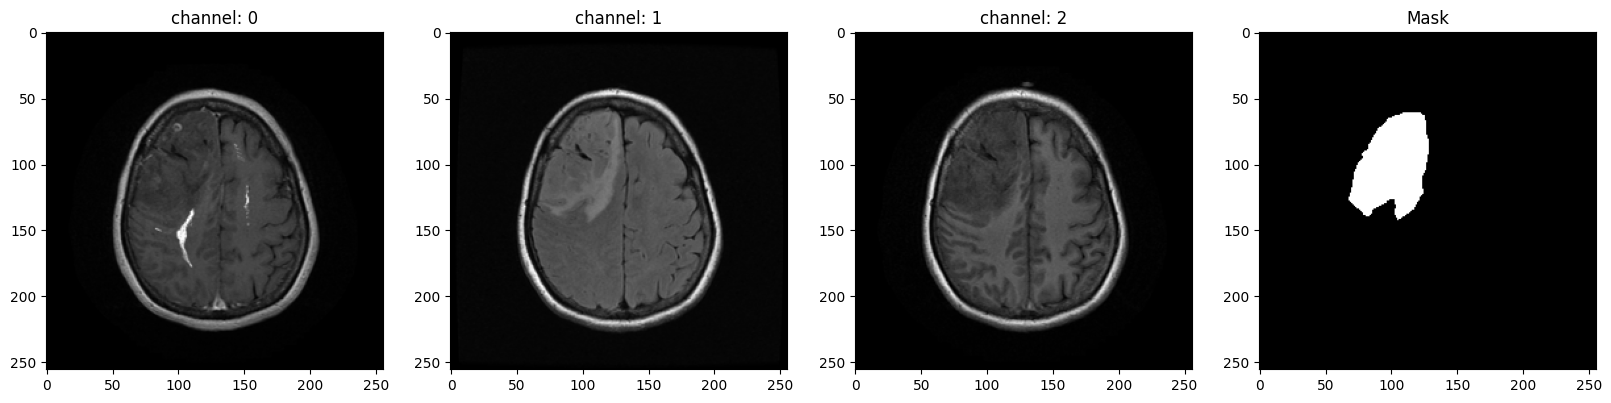

In [30]:
# show channelwise image 
plt.figure(figsize=(20, 5))
for i in range(3):
    # subplot(nrows, ncols, index, **kwargs)
    plt.subplot(1, 4, i+1)
    plt.title(f'channel: {i}')
    plt.imshow(img[:, :, i], cmap='gray')
plt.subplot(1, 4, 4)
plt.title('Mask')
plt.imshow(mask)
plt.show()

In [31]:
# Calculate tumor pixel
values, counts = np.unique(mask, return_counts=True)
values, counts

(array([  0, 255], dtype=uint8), array([186414,  10194]))

# Dataset & Dataloader



*   Image
    * shape: (H, W, 3) -> (3, H, W)
    * value: 0 ~ 255  ->  0. ~ 1.
*   Mask
    * Method 1: **Binary Segmentation**
    * Method 2: **Multi-Class Segmentation** (2 classes: **Background, Foreground**)
        * shape: (H, W, 3) -> (1, H, W)
        * value: 0 or 255  -> 0 or 1
*   Augmentation
    * imgaug: https://imgaug.readthedocs.io/en/latest/source/examples_segmentation_maps.html



In [11]:
IMG_SIZE = 256
BS = 12

In [12]:
class TumorDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, img_size, augmentation=False):
        # Read all mask paths
        self.mask_paths = glob(os.path.join(folder_path, '*_mask.tif'))
        # mask paths -> img paths
        self.img_paths = [m_path.replace('_mask', '') for m_path in self.mask_paths]
        self.img_size = img_size
        # Data Augmentation
        self.augmentation = augmentation
        self.augmentor = imgaug.augmenters.Sequential([
            imgaug.augmenters.Fliplr(0.5), # 50% horizontal flip
            imgaug.augmenters.Affine(
                rotate=(-45, 45), # random rotate -45 ~ +45 degree
                shear=(-16,16), # random shear -16 ~ +16 degree
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)} # scale x, y: 80%~120%
            ),
        ])
    def __len__(self):
        return len(self.mask_paths)
    
    def __getitem__(self, idx):
        # get img & mask path
        img_path = self.img_paths[idx]
        mask_path = self.mask_paths[idx]
        # Read img & mask
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        # Resize
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
        # convert mask to 1 channel (H, W, 3) -> (H, W, 1)
        mask = mask[:, :, :1] 
        # Normalize Image
        img = img / 255. # 0~255 -> 0~1
        # Binarize mask from [0~255] to (0 or 1)
        mask = np.where(mask<127, 0, 1).astype(np.int16)

        # Augment mask by imgaug
        if self.augmentation:
            mask = imgaug.augmentables.segmaps.SegmentationMapsOnImage(mask, 
                                                                       shape=mask.shape)
            # augment img & mask "simultaneously"
            img, mask = self.augmentor(image=img, segmentation_maps=mask)
            mask = mask.get_arr() # to np.array

        # 1. Convert to PyTorch Tensor
        # 2. Channel last to first: (H, W, C) -> (C, H, W)
        # Tensor datatype: 
        # Img: float, Mask: float
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float).permute(2, 0, 1)
        return img, mask

In [13]:
train_ds = TumorDataset('brain-mri-seg/train', 
                        IMG_SIZE, 
                        augmentation=True)
val_ds = TumorDataset('brain-mri-seg/test', 
                      IMG_SIZE)

# https://pytorch.org/docs/stable/data.html
# >0: accelerate loading data by muli-process
NUM_WORKERS = 2 

train_loader = torch.utils.data.DataLoader(train_ds, 
                                           BS, 
                                           shuffle=True, 
                                           num_workers=NUM_WORKERS)
val_loader = torch.utils.data.DataLoader(val_ds, 
                                         BS, 
                                         num_workers=NUM_WORKERS)

In [27]:
test_np = np.random.randint(1, 6, size=(3, 5, 5))
print(test_np)
test_np.transpose(1, 2, 0)

[[[2 1 4 5 1]
  [3 1 1 5 5]
  [3 3 3 1 3]
  [2 4 3 4 4]
  [1 2 4 1 4]]

 [[3 2 1 3 2]
  [2 2 3 5 3]
  [3 4 3 3 3]
  [5 5 4 4 2]
  [1 3 3 2 3]]

 [[5 5 1 1 3]
  [5 1 4 3 3]
  [2 5 5 3 5]
  [2 1 3 2 2]
  [5 1 1 4 5]]]


array([[[2, 3, 5],
        [1, 2, 5],
        [4, 1, 1],
        [5, 3, 1],
        [1, 2, 3]],

       [[3, 2, 5],
        [1, 2, 1],
        [1, 3, 4],
        [5, 5, 3],
        [5, 3, 3]],

       [[3, 3, 2],
        [3, 4, 5],
        [3, 3, 5],
        [1, 3, 3],
        [3, 3, 5]],

       [[2, 5, 2],
        [4, 5, 1],
        [3, 4, 3],
        [4, 4, 2],
        [4, 2, 2]],

       [[1, 1, 5],
        [2, 3, 1],
        [4, 3, 1],
        [1, 2, 4],
        [4, 3, 5]]])

In [29]:
test_np.transpose() # transpose

array([[[2, 3, 5],
        [3, 2, 5],
        [3, 3, 2],
        [2, 5, 2],
        [1, 1, 5]],

       [[1, 2, 5],
        [1, 2, 1],
        [3, 4, 5],
        [4, 5, 1],
        [2, 3, 1]],

       [[4, 1, 1],
        [1, 3, 4],
        [3, 3, 5],
        [3, 4, 3],
        [4, 3, 1]],

       [[5, 3, 1],
        [5, 5, 3],
        [1, 3, 3],
        [4, 4, 2],
        [1, 2, 4]],

       [[1, 2, 3],
        [5, 3, 3],
        [3, 3, 5],
        [4, 2, 2],
        [4, 3, 5]]])

Visulize data

img.shape:  torch.Size([3, 256, 256]) 
mask.shape:  torch.Size([1, 256, 256])


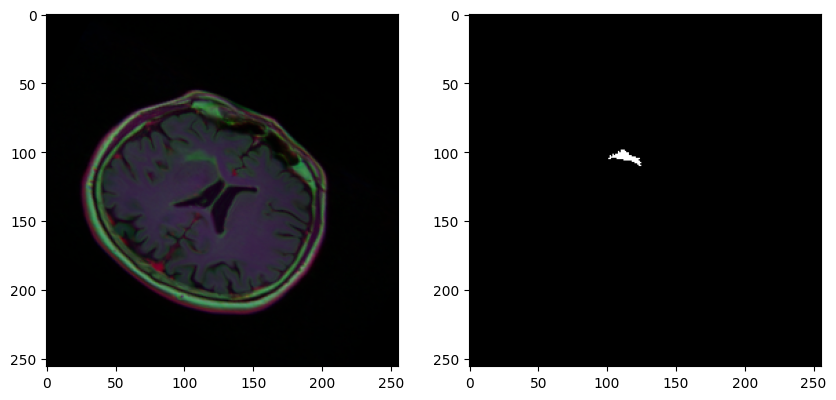

In [32]:
img, mask = train_ds[0] # take 1 data
print('img.shape: ', img.shape, '\nmask.shape: ', mask.shape)
img = img.numpy().transpose(1, 2, 0) # (C, H, W) -> (H, W, C)
mask = mask.numpy().squeeze() # (1, H, W) -> (H, W)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.show()

#### Build Model

In [33]:
# Basic Conv block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            # conv bn relu 
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    def __call__(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()
        # Encoder
        self.encoder1 = ConvBlock(in_channels, init_features) # (3, H, W) -> (32, H, W)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = ConvBlock(init_features, init_features*2) # (32, H/2, W/2) -> (64, H/2, W/2)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = ConvBlock(init_features*2, init_features*4) # (64, H/4, W/4) -> (128, H/4, W/4)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = ConvBlock(init_features*4, init_features*8) # (128, H/8, W/8) -> (256, H/8, W/8)
        self.pool4 = nn.MaxPool2d(2)
        self.encoder5 = ConvBlock(init_features*8, init_features*16) # (256, H/16, W/16) -> (512, H/16, W/16)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(init_features*16, # (512, H/16, W/16) -> (256, H/8, W/8)
                                          init_features*8,
                                          kernel_size=2, stride=2)
        self.decoder4 = ConvBlock(init_features*8*2, init_features*8)
        self.upconv3 = nn.ConvTranspose2d(init_features*8, # (256, H/8, W/8) -> (128, H/4, W/4)
                                          init_features*4, 
                                          kernel_size=2, stride=2)
        self.decoder3 = ConvBlock(init_features*4*2, init_features*4)
        self.upconv2 = nn.ConvTranspose2d(init_features*4, # (128, H/4, W/4) -> (64, H/2, W/2)
                                          init_features*2,
                                          kernel_size=2, stride=2)
        self.decoder2 = ConvBlock(init_features*2*2, init_features*2)
        self.upconv1 = nn.ConvTranspose2d(init_features*2, # (62, H/2, W/2) -> (32, H, W)
                                          init_features,
                                          kernel_size=2, stride=2)
        self.decoder1 = ConvBlock(init_features*2, init_features)
        # Output: binary segmentation, C=1
        self.output = nn.Conv2d(init_features, 
                                out_channels=1, 
                                kernel_size=1) # (32, H, W) -> (1, H, W)

    def __call__(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        bottleneck = self.encoder5(self.pool4(enc4))
        # Decoder
        # (BS, 256, H/8, W/8) + (BS, 256, H/8, W/8) -> (BS, 512, H/8, W/8)
        x = torch.cat((self.upconv4(bottleneck), enc4), dim=1) 
        x = self.decoder4(x)

        x = torch.cat((self.upconv3(x), enc3), dim=1)
        x = self.decoder3(x)
        
        x = torch.cat((self.upconv2(x), enc2), dim=1)
        x = self.decoder2(x)
        
        x = torch.cat((self.upconv1(x), enc1), dim=1)
        x = self.decoder1(x)
        
        x = torch.sigmoid(self.output(x))
        return x

In [34]:
# build model to GPU
model = UNet().to(device)

In [35]:
# Summary
torchsummary.summary(model, (3, 256, 256), device=device)

# for c in model.children():
#     print(c)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,496
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,928
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1, 64,

#### Loss function for segmentation

**Loss functin for segmentation**


1.   Cross Entropy
2.   Dice Loss
3.   IoU Loss

ref: https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch/notebook


**2. Dice Loss**

Dice coefficient, or Dice-Sørensen coefficient

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/a80a97215e1afc0b222e604af1b2099dc9363d3b)

In [36]:
# PyTorch Dice loss
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        return 1 - dice

**3. IoU Loss: Intersection over Union Loss**

IoU (Jaccard Index)

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/eaef5aa86949f49e7dc6b9c8c3dd8b233332c9e7)

In [37]:
# PyTorch IoU
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True, loss=True):
        super(IoULoss, self).__init__()
        self.loss = loss

    def forward(self, inputs, targets, smooth=1):
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # intersection: True Positive count
        # union: mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        iou = (intersection + smooth)/(union + smooth)
        # return IoU loss or IoU value
        if self.loss:
          return 1 - iou
        else:
          return iou

#### Training

In [38]:
# Average binary accuracy for all pixel in a batch
def get_binary_accuracy(y_true, y_prob):
    assert y_true.size() == y_prob.size()
    y_prob = y_prob > 0.5
    return (y_true == y_prob).sum().item() / y_true.nelement()

def train_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    iou = IoULoss(loss=False)
    model.train() # Sets the model in training mode.
    epoch_loss, epoch_acc, epoch_iou = 0, [], []
    for batch_i, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device) # move data to GPU
        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)
        # Optimization by gradients
        optimizer.zero_grad() # set prevision gradient to 0
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params
        # log
        epoch_loss += loss.item()
        epoch_acc.append(get_binary_accuracy(y, pred))
        epoch_iou.append(iou(pred, y).item())
    # return avg loss of epoch, avg acc of epoch
    return epoch_loss/num_batches, np.mean(epoch_acc), np.mean(epoch_iou)
    

def test_epoch(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    iou = IoULoss(loss=False)
    model.eval() # Sets the model in test mode.
    epoch_loss, epoch_acc, epoch_iou = 0, [], []
    # No training for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)
            # write to logs
            epoch_loss += loss.item()
            epoch_acc.append(get_binary_accuracy(y, pred))
            epoch_iou.append(iou(pred, y).item())
    return epoch_loss/num_batches, np.mean(epoch_acc), np.mean(epoch_iou)

In [39]:
def train(loss_fn, epochs=10, save=False, model_path='model.pth'):
    # Model
    model = UNet().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    EPOCHS = epochs
    logs = {
        'train_loss': [], 'train_acc': [], 
        'val_loss': [], 'val_acc': [],
        'train_iou': [], 'val_iou': []
    }
    for epoch in tqdm(range(EPOCHS)):
        train_loss, train_acc, train_iou = train_epoch(train_loader, model, loss_fn, optimizer)
        val_loss, val_acc, val_iou = test_epoch(val_loader, model, loss_fn)

        print(f'EPOCH: {epoch:04d} \
        train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f}, train_iou: {train_iou:.3f} \
        val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f}, val_iou: {val_iou:.3f} ')

        logs['train_loss'].append(train_loss)
        logs['train_acc'].append(train_acc)
        logs['train_iou'].append(train_iou)
        logs['val_loss'].append(val_loss)
        logs['val_acc'].append(val_acc)
        logs['val_iou'].append(val_iou)
        

    # plot result
    plt.figure(figsize=(9, 3))
    plt.subplot(1, 3, 1)
    plt.title('Loss')
    plt.plot(logs['train_loss'])
    plt.plot(logs['val_loss'])
    plt.subplot(1, 3, 2)
    plt.title('Acc.')
    plt.plot(logs['train_acc'])
    plt.plot(logs['val_acc'])
    plt.subplot(1, 3, 3)
    plt.title('IoU')
    plt.plot(logs['train_iou'])
    plt.plot(logs['val_iou'])
    plt.show()

    # Save model
    if save:
        torch.save(model.state_dict(), model_path)

 10%|█         | 1/10 [00:26<03:55, 26.19s/it]

EPOCH: 0000         train_loss: 0.2333, train_acc: 0.976, train_iou: 0.087         val_loss: 0.1473, val_acc: 0.981, val_iou: 0.126 


 20%|██        | 2/10 [00:51<03:27, 25.95s/it]

EPOCH: 0001         train_loss: 0.1023, train_acc: 0.983, train_iou: 0.167         val_loss: 0.3748, val_acc: 0.836, val_iou: 0.131 


 30%|███       | 3/10 [01:18<03:03, 26.28s/it]

EPOCH: 0002         train_loss: 0.0657, train_acc: 0.985, train_iou: 0.257         val_loss: 0.1147, val_acc: 0.958, val_iou: 0.240 


 40%|████      | 4/10 [01:45<02:38, 26.47s/it]

EPOCH: 0003         train_loss: 0.0515, train_acc: 0.986, train_iou: 0.324         val_loss: 0.0570, val_acc: 0.983, val_iou: 0.378 


 50%|█████     | 5/10 [02:11<02:11, 26.39s/it]

EPOCH: 0004         train_loss: 0.0443, train_acc: 0.987, train_iou: 0.381         val_loss: 0.0461, val_acc: 0.985, val_iou: 0.417 


 60%|██████    | 6/10 [02:37<01:45, 26.32s/it]

EPOCH: 0005         train_loss: 0.0402, train_acc: 0.987, train_iou: 0.417         val_loss: 0.0425, val_acc: 0.986, val_iou: 0.419 


 70%|███████   | 7/10 [03:04<01:19, 26.39s/it]

EPOCH: 0006         train_loss: 0.0369, train_acc: 0.988, train_iou: 0.448         val_loss: 0.0449, val_acc: 0.985, val_iou: 0.445 


 80%|████████  | 8/10 [03:30<00:52, 26.39s/it]

EPOCH: 0007         train_loss: 0.0352, train_acc: 0.988, train_iou: 0.466         val_loss: 0.0525, val_acc: 0.984, val_iou: 0.415 


 90%|█████████ | 9/10 [03:57<00:26, 26.37s/it]

EPOCH: 0008         train_loss: 0.0334, train_acc: 0.989, train_iou: 0.488         val_loss: 0.0407, val_acc: 0.985, val_iou: 0.468 


100%|██████████| 10/10 [04:23<00:00, 26.34s/it]

EPOCH: 0009         train_loss: 0.0332, train_acc: 0.988, train_iou: 0.493         val_loss: 0.0401, val_acc: 0.986, val_iou: 0.501 


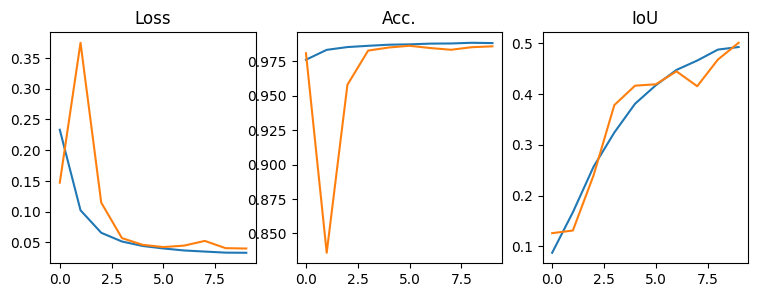

 10%|█         | 1/10 [00:26<03:57, 26.36s/it]

EPOCH: 0000         train_loss: 0.8504, train_acc: 0.846, train_iou: 0.081         val_loss: 0.7829, val_acc: 0.961, val_iou: 0.122 


 20%|██        | 2/10 [00:52<03:32, 26.51s/it]

EPOCH: 0001         train_loss: 0.6318, train_acc: 0.974, train_iou: 0.232         val_loss: 0.4534, val_acc: 0.982, val_iou: 0.380 


 30%|███       | 3/10 [01:19<03:05, 26.53s/it]

EPOCH: 0002         train_loss: 0.3695, train_acc: 0.984, train_iou: 0.470         val_loss: 0.3781, val_acc: 0.983, val_iou: 0.460 


 40%|████      | 4/10 [01:45<02:38, 26.45s/it]

EPOCH: 0003         train_loss: 0.2911, train_acc: 0.986, train_iou: 0.555         val_loss: 0.2692, val_acc: 0.984, val_iou: 0.580 


 50%|█████     | 5/10 [02:12<02:11, 26.37s/it]

EPOCH: 0004         train_loss: 0.2712, train_acc: 0.986, train_iou: 0.578         val_loss: 0.2740, val_acc: 0.985, val_iou: 0.574 


 60%|██████    | 6/10 [02:38<01:45, 26.32s/it]

EPOCH: 0005         train_loss: 0.2524, train_acc: 0.987, train_iou: 0.603         val_loss: 0.2889, val_acc: 0.986, val_iou: 0.561 


 70%|███████   | 7/10 [03:04<01:18, 26.30s/it]

EPOCH: 0006         train_loss: 0.2479, train_acc: 0.987, train_iou: 0.609         val_loss: 0.2608, val_acc: 0.986, val_iou: 0.594 


 80%|████████  | 8/10 [03:30<00:52, 26.32s/it]

EPOCH: 0007         train_loss: 0.2323, train_acc: 0.988, train_iou: 0.627         val_loss: 0.2340, val_acc: 0.987, val_iou: 0.629 


 90%|█████████ | 9/10 [03:57<00:26, 26.29s/it]

EPOCH: 0008         train_loss: 0.2103, train_acc: 0.989, train_iou: 0.656         val_loss: 0.2105, val_acc: 0.987, val_iou: 0.656 


100%|██████████| 10/10 [04:23<00:00, 26.34s/it]

EPOCH: 0009         train_loss: 0.2108, train_acc: 0.989, train_iou: 0.656         val_loss: 0.2196, val_acc: 0.987, val_iou: 0.644 


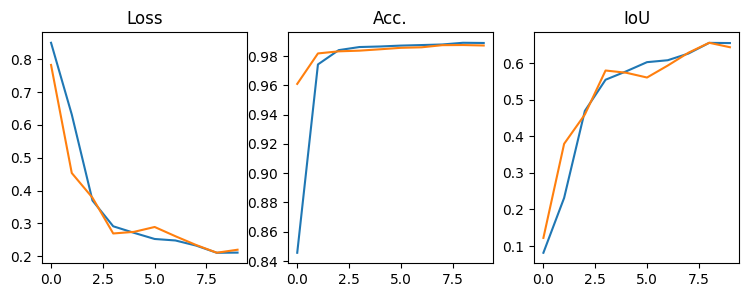

 10%|█         | 1/10 [00:26<04:02, 26.93s/it]

EPOCH: 0000         train_loss: 0.9097, train_acc: 0.899, train_iou: 0.090         val_loss: 0.8556, val_acc: 0.949, val_iou: 0.144 


 20%|██        | 2/10 [00:53<03:34, 26.79s/it]

EPOCH: 0001         train_loss: 0.7364, train_acc: 0.972, train_iou: 0.264         val_loss: 0.6369, val_acc: 0.969, val_iou: 0.363 


 30%|███       | 3/10 [01:19<03:05, 26.55s/it]

EPOCH: 0002         train_loss: 0.4977, train_acc: 0.984, train_iou: 0.502         val_loss: 0.4747, val_acc: 0.981, val_iou: 0.525 


 40%|████      | 4/10 [01:46<02:38, 26.46s/it]

EPOCH: 0003         train_loss: 0.4344, train_acc: 0.986, train_iou: 0.566         val_loss: 0.4258, val_acc: 0.983, val_iou: 0.574 


 50%|█████     | 5/10 [02:12<02:12, 26.45s/it]

EPOCH: 0004         train_loss: 0.4161, train_acc: 0.986, train_iou: 0.584         val_loss: 0.4279, val_acc: 0.985, val_iou: 0.572 


 60%|██████    | 6/10 [02:38<01:45, 26.41s/it]

EPOCH: 0005         train_loss: 0.3915, train_acc: 0.987, train_iou: 0.609         val_loss: 0.4634, val_acc: 0.979, val_iou: 0.537 


 70%|███████   | 7/10 [03:05<01:19, 26.35s/it]

EPOCH: 0006         train_loss: 0.4090, train_acc: 0.987, train_iou: 0.591         val_loss: 0.4319, val_acc: 0.984, val_iou: 0.568 


 80%|████████  | 8/10 [03:31<00:52, 26.34s/it]

EPOCH: 0007         train_loss: 0.3806, train_acc: 0.987, train_iou: 0.619         val_loss: 0.4775, val_acc: 0.984, val_iou: 0.522 


 90%|█████████ | 9/10 [03:57<00:26, 26.31s/it]

EPOCH: 0008         train_loss: 0.3779, train_acc: 0.988, train_iou: 0.622         val_loss: 0.4031, val_acc: 0.983, val_iou: 0.597 


100%|██████████| 10/10 [04:24<00:00, 26.41s/it]

EPOCH: 0009         train_loss: 0.3648, train_acc: 0.988, train_iou: 0.635         val_loss: 0.3772, val_acc: 0.986, val_iou: 0.623 


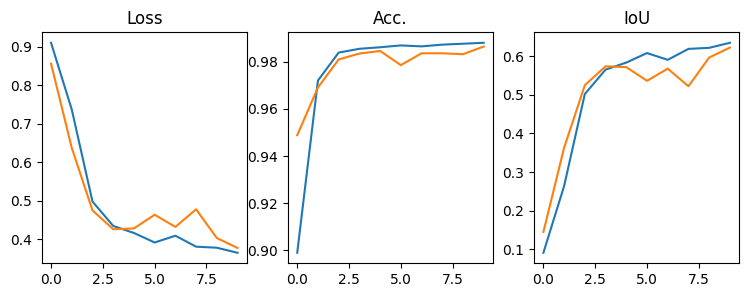

In [40]:
EPOCHS = 10

train(loss_fn=nn.BCELoss(), epochs=EPOCHS, model_path='model_bce.pth')
train(loss_fn=DiceLoss(), epochs=EPOCHS, model_path='model_dice.pth')
train(loss_fn=IoULoss(), epochs=EPOCHS, model_path='model_iou.pth')

  5%|▌         | 1/20 [00:25<08:10, 25.82s/it]

EPOCH: 0000         train_loss: 0.8498, train_acc: 0.910, train_iou: 0.082         val_loss: 0.8272, val_acc: 0.800, val_iou: 0.095 


 10%|█         | 2/20 [00:51<07:42, 25.68s/it]

EPOCH: 0001         train_loss: 0.7046, train_acc: 0.968, train_iou: 0.176         val_loss: 0.5364, val_acc: 0.981, val_iou: 0.304 


 15%|█▌        | 3/20 [01:17<07:18, 25.77s/it]

EPOCH: 0002         train_loss: 0.4345, train_acc: 0.983, train_iou: 0.400         val_loss: 0.4357, val_acc: 0.971, val_iou: 0.396 


 20%|██        | 4/20 [01:43<06:52, 25.80s/it]

EPOCH: 0003         train_loss: 0.3153, train_acc: 0.985, train_iou: 0.525         val_loss: 0.2922, val_acc: 0.984, val_iou: 0.552 


 25%|██▌       | 5/20 [02:09<06:27, 25.83s/it]

EPOCH: 0004         train_loss: 0.2778, train_acc: 0.986, train_iou: 0.569         val_loss: 0.3100, val_acc: 0.984, val_iou: 0.531 


 30%|███       | 6/20 [02:35<06:02, 25.89s/it]

EPOCH: 0005         train_loss: 0.2749, train_acc: 0.986, train_iou: 0.574         val_loss: 0.2478, val_acc: 0.986, val_iou: 0.607 


 35%|███▌      | 7/20 [03:01<05:37, 25.95s/it]

EPOCH: 0006         train_loss: 0.2490, train_acc: 0.987, train_iou: 0.606         val_loss: 0.2715, val_acc: 0.986, val_iou: 0.580 


 40%|████      | 8/20 [03:27<05:11, 25.98s/it]

EPOCH: 0007         train_loss: 0.2388, train_acc: 0.987, train_iou: 0.619         val_loss: 0.3204, val_acc: 0.979, val_iou: 0.521 


 45%|████▌     | 9/20 [03:53<04:45, 25.99s/it]

EPOCH: 0008         train_loss: 0.2353, train_acc: 0.988, train_iou: 0.624         val_loss: 0.2738, val_acc: 0.986, val_iou: 0.579 


 50%|█████     | 10/20 [04:19<04:20, 26.02s/it]

EPOCH: 0009         train_loss: 0.2212, train_acc: 0.988, train_iou: 0.642         val_loss: 0.2406, val_acc: 0.987, val_iou: 0.618 


 55%|█████▌    | 11/20 [04:45<03:54, 26.05s/it]

EPOCH: 0010         train_loss: 0.2099, train_acc: 0.989, train_iou: 0.656         val_loss: 0.4090, val_acc: 0.981, val_iou: 0.430 


 60%|██████    | 12/20 [05:11<03:28, 26.09s/it]

EPOCH: 0011         train_loss: 0.2194, train_acc: 0.988, train_iou: 0.645         val_loss: 0.2124, val_acc: 0.988, val_iou: 0.655 


 65%|██████▌   | 13/20 [05:37<03:02, 26.12s/it]

EPOCH: 0012         train_loss: 0.2012, train_acc: 0.989, train_iou: 0.669         val_loss: 0.2065, val_acc: 0.988, val_iou: 0.663 


 70%|███████   | 14/20 [06:03<02:36, 26.16s/it]

EPOCH: 0013         train_loss: 0.1857, train_acc: 0.990, train_iou: 0.690         val_loss: 0.1855, val_acc: 0.988, val_iou: 0.689 


 75%|███████▌  | 15/20 [06:30<02:10, 26.20s/it]

EPOCH: 0014         train_loss: 0.2000, train_acc: 0.989, train_iou: 0.670         val_loss: 0.2159, val_acc: 0.988, val_iou: 0.651 


 80%|████████  | 16/20 [06:56<01:44, 26.22s/it]

EPOCH: 0015         train_loss: 0.2044, train_acc: 0.989, train_iou: 0.666         val_loss: 0.2072, val_acc: 0.989, val_iou: 0.663 


 85%|████████▌ | 17/20 [07:22<01:18, 26.25s/it]

EPOCH: 0016         train_loss: 0.1900, train_acc: 0.990, train_iou: 0.685         val_loss: 0.2418, val_acc: 0.987, val_iou: 0.617 


 90%|█████████ | 18/20 [07:49<00:52, 26.25s/it]

EPOCH: 0017         train_loss: 0.1964, train_acc: 0.990, train_iou: 0.676         val_loss: 0.2104, val_acc: 0.988, val_iou: 0.657 


 95%|█████████▌| 19/20 [08:15<00:26, 26.26s/it]

EPOCH: 0018         train_loss: 0.1879, train_acc: 0.990, train_iou: 0.687         val_loss: 0.1822, val_acc: 0.989, val_iou: 0.695 


100%|██████████| 20/20 [08:41<00:00, 26.10s/it]

EPOCH: 0019         train_loss: 0.1860, train_acc: 0.990, train_iou: 0.689         val_loss: 0.1768, val_acc: 0.990, val_iou: 0.702 


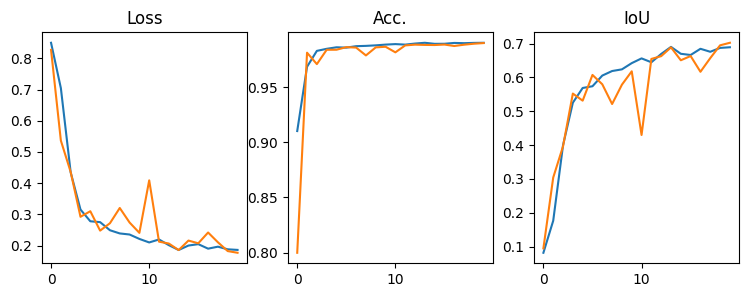

In [57]:
train(loss_fn=DiceLoss(), epochs=20, save=True, model_path='model_dice.pth')

In [ ]:
# dice loss = 1 - dice

#### Evaluation

In [54]:
model = UNet().to(device)
model.load_state_dict(torch.load('model_dice.pth'))

<All keys matched successfully>

data idx:  24


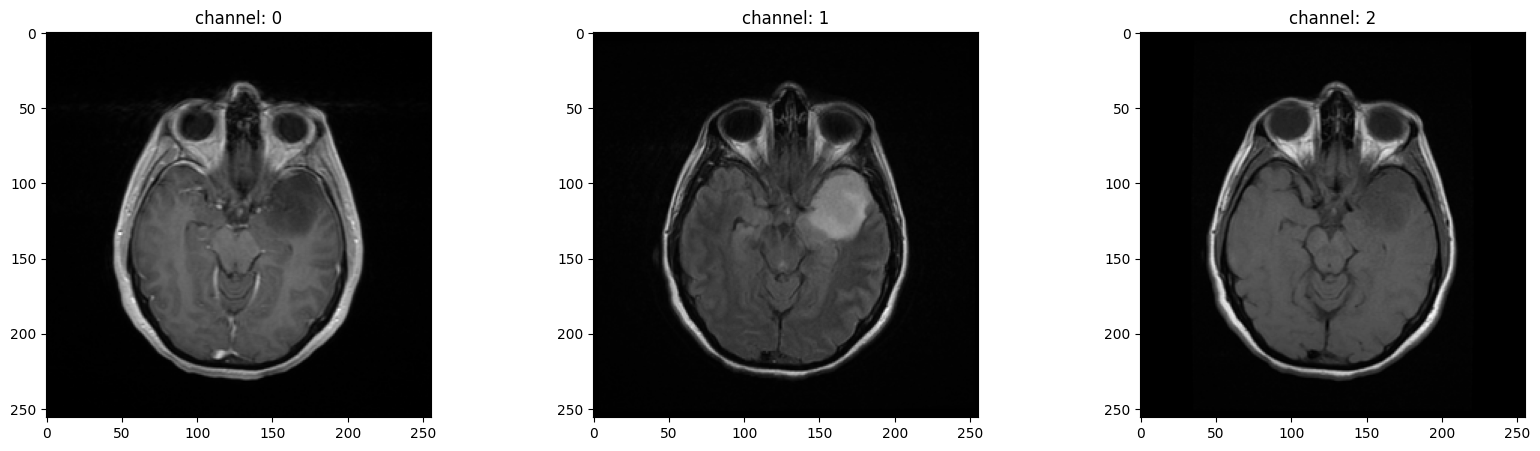

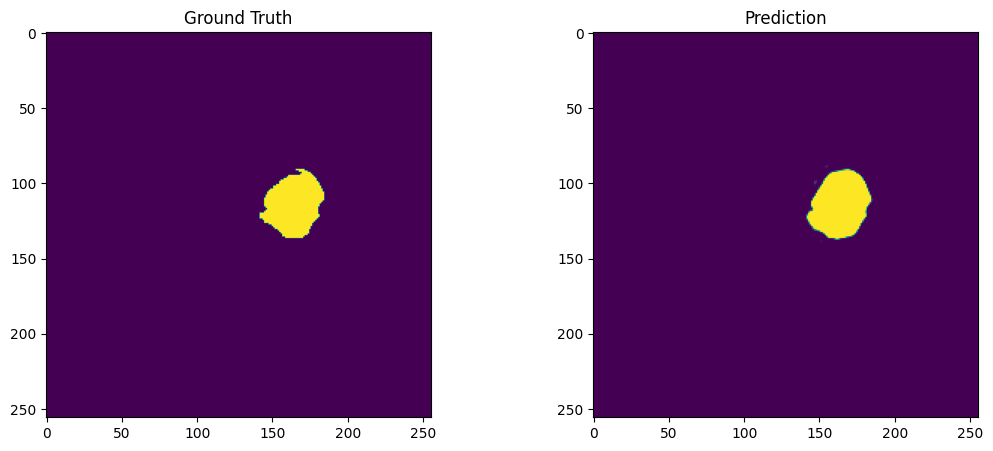

In [55]:
# Sample 1 img
idx = np.random.randint(len(val_loader.dataset))
print('data idx: ', idx)
data = val_loader.dataset[idx]
img, mask = data # (3, 256, 256), (1, 256, 256)
img = img.to(device)
img = img.unsqueeze(dim=0) # add batch dim: (1, 3, 256, 256) 
mask_pred = model(img)

# To Numpy as cpu
img = img[0].permute(1, 2, 0).cpu().numpy() # (1, 3, 256, 256) -> (256, 256, 3)
mask = mask.permute(1, 2, 0).numpy() # (1, 256, 256) -> (256, 256, 1)
mask_pred = mask_pred[0].permute(1, 2, 0).cpu().detach().numpy() # (1, 1, 256, 256) -> (256, 256, 1)

# show inputs by channel
plt.figure(figsize=(20, 5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(f'channel: {i}')
    plt.imshow(img[:, :, i], cmap='gray')
plt.show()

# show ground truth & model prediction
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.title('Ground Truth')
plt.imshow(mask[:, :, 0]) # (256, 256, 1) -> (256, 256)
plt.subplot(1, 3, 2)
plt.title('Prediction')
plt.imshow(mask_pred[:, :, 0]) # (256, 256, 1) -> (256, 256)
plt.show()
# plt.imshow(mask_pred[:, :, 0], cmap='gray')

**By threshold** : 0.0 ~ 0.9

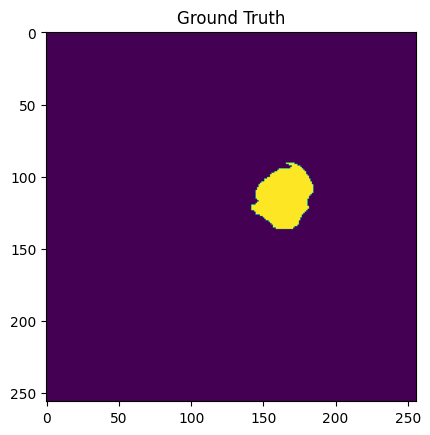

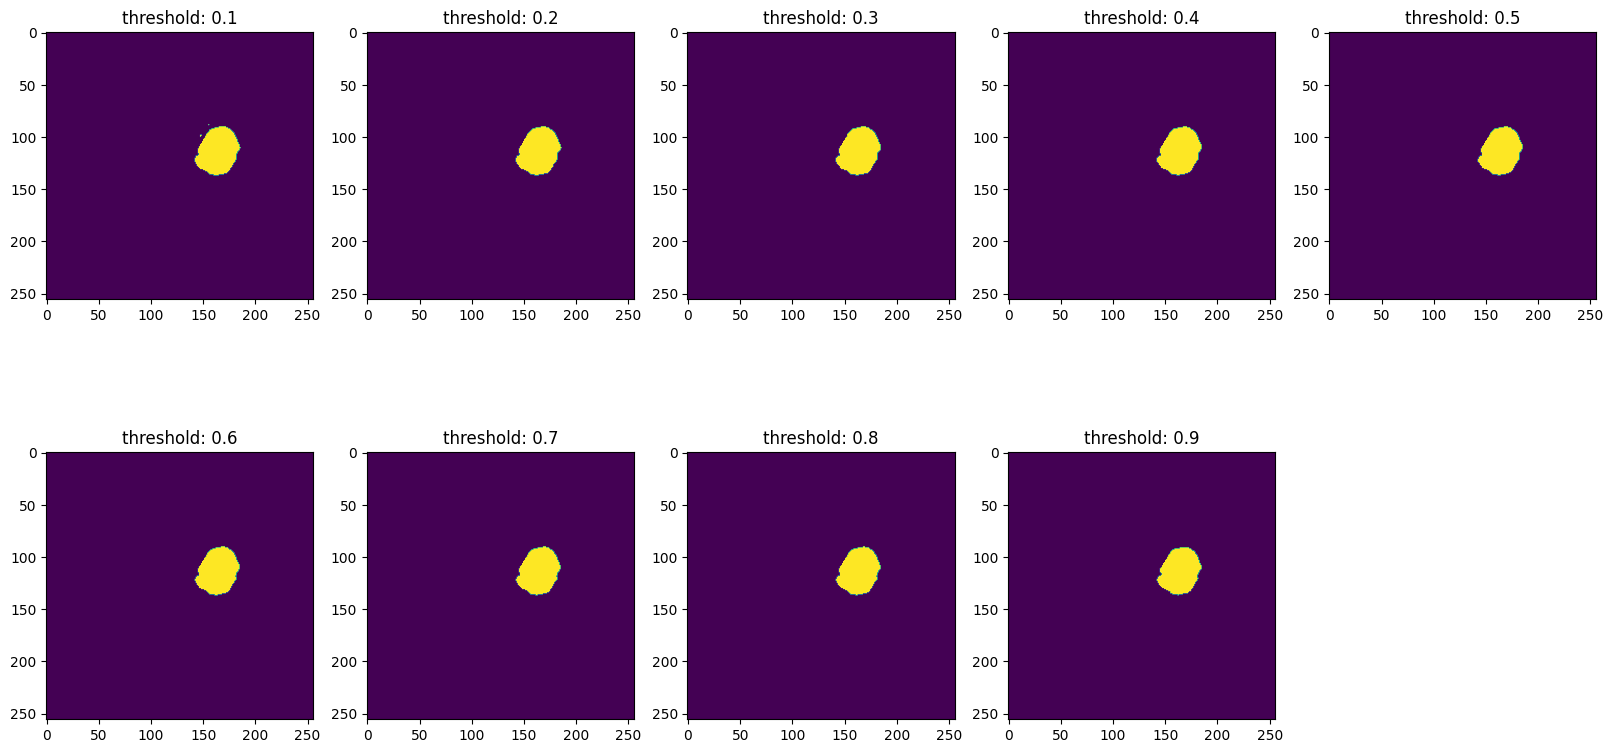

In [58]:
plt.imshow(mask[:, :, 0])
plt.title('Ground Truth')
plt.show()

plt.figure(figsize=(20, 10))
for i in range(1, 10):
    plt.subplot(2, 5, i)
    threshold = i * 0.1
    mask_threshold = mask_pred.copy()
    mask_threshold[mask_threshold <= threshold] = 0.
    mask_threshold[mask_threshold > threshold] = 1.
    plt.imshow(mask_threshold[:, :, 0])
    plt.title(f'threshold: {threshold:.1f}')
plt.show()

# Visualize model

1.   netron: 
    https://github.com/lutzroeder/netron, 
    
    https://netron.app/
2.   torchinfo: https://github.com/TylerYep/torchinfo



**1. Netron**

In [46]:
!pip install netron
import netron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.7 MB/s eta 0:00:00


In [49]:
!pip install onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 95.6 MB/s eta 0:00:00


In [50]:
x = torch.randn(2, 3, 256, 256).to(device)
y = model(x)
torch.onnx.export(model, x, 'model.onnx')

# upload to https://netron.app/

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



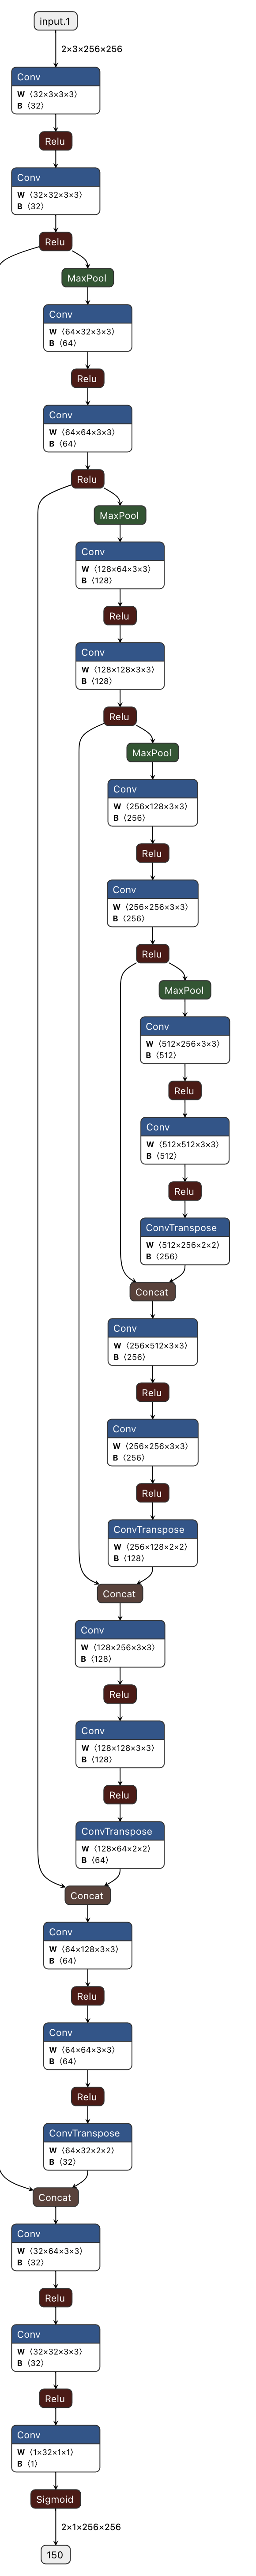

**2. torchinfo**

In [51]:
!pip install torchinfo
from torchinfo import summary

summary(model, input_size=(2, 3, 256, 256))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         --                        --
│    └─Sequential: 2-1                   [2, 32, 256, 256]         --
│    │    └─Conv2d: 3-1                  [2, 32, 256, 256]         896
│    │    └─BatchNorm2d: 3-2             [2, 32, 256, 256]         64
│    │    └─ReLU: 3-3                    [2, 32, 256, 256]         --
│    │    └─Conv2d: 3-4                  [2, 32, 256, 256]         9,248
│    │    └─BatchNorm2d: 3-5             [2, 32, 256, 256]         64
│    │    └─ReLU: 3-6                    [2, 32, 256, 256]         --
├─MaxPool2d: 1-2                         [2, 32, 128, 128]         --
├─ConvBlock: 1-3                         --                        --
│    └─Sequential: 2-2                   [2, 64, 128, 128]         --
│    │    └─Conv2d: 3-7                  [2, 64, 128, 128]         18,496
│    │    └─BatchNorm2d: 3-8             [2, 64, 128, 128]         128
│    │